# Red neuronal para la clasificación de BOFs en una escena

In [1]:
import numpy as np
from tensorflow import keras
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay, classification_report

2022-03-14 22:55:14.424684: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-03-14 22:55:14.424729: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [ ]:
!wget "https://drive.google.com/uc?export=download&id=12165ZasRQwevTb2JzRZ8sYB8EU-BhWGj" -O bofs.npy
!wget "https://drive.google.com/uc?export=download&id=1GJZmRwiRLPo8yANRct873ZrVNKWYitjU" -O targets.npy

--2022-03-08 02:45:34--  https://drive.google.com/uc?export=download&id=12165ZasRQwevTb2JzRZ8sYB8EU-BhWGj
Resolving drive.google.com (drive.google.com)... 74.125.142.139, 74.125.142.102, 74.125.142.100, ...
Connecting to drive.google.com (drive.google.com)|74.125.142.139|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-14-ac-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/ev57ej7nok915riidrgodd68nhi5semh/1646707500000/13400443621396335819/*/12165ZasRQwevTb2JzRZ8sYB8EU-BhWGj?e=download [following]
--2022-03-08 02:45:35--  https://doc-14-ac-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/ev57ej7nok915riidrgodd68nhi5semh/1646707500000/13400443621396335819/*/12165ZasRQwevTb2JzRZ8sYB8EU-BhWGj?e=download
Resolving doc-14-ac-docs.googleusercontent.com (doc-14-ac-docs.googleusercontent.com)... 108.177.98.132, 2607:f8b0:400e:c06::84
Connecting to doc-14-ac-docs.googleusercontent.com (doc-14-ac-docs

In [2]:
bofs = np.load('bofs.npy')
targets = np.load('targets.npy')

## Análisis exploratorio de datos

In [3]:
print(bofs.shape)
print(targets.shape)

(4991, 180)
(4991,)


El arreglo de *bofs* contiene 4173 descriptores, cada uno de tamaño 180.

In [4]:
np.unique(targets, return_counts=True)

(array([0., 1., 2., 3.]), array([ 714, 2036, 1081, 1160]))

El arrgelo *targets* contiene la clase asignada a cada BOF, la cual, está relacionada con la zona (ubicación) a la que pertenece la cada BOF.

De igual forma se realiza el conteo de los valores únicos. Se puede observar que la clase con menos valores es la 0, la cual tiene aproximadamente una tercera parte del contenido de la clase 1.

A continuación se calculan la media y varianza de los descriptores, esto para estandarizar los datos y permitir que la red neuronal converja.

In [5]:
bofs_mean = np.mean(bofs)
bofs_var = np.var(bofs)
print(bofs_mean)
print(bofs_var)

0.42726931136427476
0.07275525300800657


## División de datos para entrenamiento, validación y prueba
- 70\% entrenamiento
- 15% validación
- 15% prueba

In [6]:
X_train, X_test, y_train, y_test = train_test_split(bofs, targets,
    test_size=0.15, shuffle = True, random_state = 8)

In [7]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train,
    test_size=3/17, shuffle = True, random_state = 8)

In [8]:
# Los datos objetivo son transformados a vectores one-hot para poder
# realizar el entrenamiento
y_train_oh = keras.utils.to_categorical(y_train, 4)
y_val_oh = keras.utils.to_categorical(y_val, 4)
y_test_oh = keras.utils.to_categorical(y_test, 4)

In [9]:
print(X_train.shape)
print(y_test_oh.shape)
print(y_val_oh.shape)
print(y_train_oh[:3], y_train[:3])

(3493, 180)
(749, 4)
(749, 4)
[[0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]] [1. 2. 1.]


## Definición de la arquitectura
Según un articulo publicado en 2021
([nota de revista](https://www.quantamagazine.org/computer-scientists-prove-why-bigger-neural-networks-do-better-20220210),
[articulo](https://arxiv.org/abs/2105.12806)),
*se requieren $n\times d$ parámetros para ajustar suavente un modelo de aprendizaje*, dónde $n$ es el número de puntos en el conjunto de datos de entrenamiento, mientras que $d$ es la dimensión de los datos.

Para el caso de este proyecto, se supondrá $n=2100$ (número de BOFs de entrenamiento), mientras que $d=180$ (dimensionalidad de cada BOF).  
Por lo tanto se requieren $n \times d = 378000$ parámetros.



In [10]:
def BOF_nn(mean,variance):
    inputs = keras.Input(shape=(180,))
    x = keras.layers.Normalization(mean=mean,variance=variance)(inputs)
    x = keras.layers.Dense(units=180*2,activation="elu")(x)
    x = keras.layers.Dense(units=180*3,activation="elu")(x)
    x = keras.layers.Dense(units=180*2,activation="elu")(x)
    x = keras.layers.Dense(units=180,activation="elu")(x)
    outputs = keras.layers.Dense(units=4,activation="softmax")(x)

    model = keras.Model(inputs, outputs)
    return model

In [11]:
model = BOF_nn(bofs_mean,bofs_var)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 180)]             0         
                                                                 
 normalization (Normalizatio  (None, 180)              0         
 n)                                                              
                                                                 
 dense (Dense)               (None, 360)               65160     
                                                                 
 dense_1 (Dense)             (None, 540)               194940    
                                                                 
 dense_2 (Dense)             (None, 360)               194760    
                                                                 
 dense_3 (Dense)             (None, 180)               64980     
                                                             

2022-03-14 22:56:48.264944: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-03-14 22:56:48.264970: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-03-14 22:56:48.264995: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (pavilion13-neon): /proc/driver/nvidia/version does not exist
2022-03-14 22:56:48.265650: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [12]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [13]:
%%time
model.fit(
    X_train, 
    y_train_oh,
    batch_size=1024, 
    epochs=50,
    validation_data=(X_val, y_val_oh),
)

Epoch 1/50
4/4 [==============================] - 1s 113ms/step - loss: 2.0492 - accuracy: 0.3498 - val_loss: 1.4489 - val_accuracy: 0.3712
Epoch 2/50
4/4 [==============================] - 0s 60ms/step - loss: 1.3712 - accuracy: 0.4145 - val_loss: 1.2490 - val_accuracy: 0.4887
Epoch 3/50
4/4 [==============================] - 0s 61ms/step - loss: 1.2319 - accuracy: 0.4658 - val_loss: 1.1521 - val_accuracy: 0.4619
Epoch 4/50
4/4 [==============================] - 0s 63ms/step - loss: 1.1344 - accuracy: 0.4684 - val_loss: 1.1139 - val_accuracy: 0.4967
Epoch 5/50
4/4 [==============================] - 0s 51ms/step - loss: 1.0834 - accuracy: 0.5202 - val_loss: 1.0823 - val_accuracy: 0.5194
Epoch 6/50
4/4 [==============================] - 0s 62ms/step - loss: 1.0541 - accuracy: 0.5385 - val_loss: 1.0624 - val_accuracy: 0.5260
Epoch 7/50
4/4 [==============================] - 0s 60ms/step - loss: 1.0209 - accuracy: 0.5580 - val_loss: 1.0326 - val_accuracy: 0.5594
Epoch 8/50
4/4 [==========

## Evaluación del modelo

Evalua la función de perdida (entropia cruzada) y la exactitud del modelo utilziando los datos de prueba.

In [14]:
loss, acc = model.evaluate(x=X_test,y=y_test_oh)
print("loss: %.2f" % loss)
print("acc: %.2f" % acc)


24/24 [==============================] - 0s 3ms/step - loss: 0.8921 - accuracy: 0.6702
loss: 0.89
acc: 0.67


In [15]:
predictions = model.predict(X_test)
predictions.shape

(749, 4)

La clase está definida por $y \in {1,\cdots,K}$

La clasificación se realza de la siguiente forma
$$ y_{pred}(x) = \operatorname*{argmax}_{k \in \{1,\cdots,K\}} \left(a_k(x)\right)  $$

Dónde $a_k$ es cada una de las neuronas de salida de la red, $x$ el vector de entrada.

A continuación se calculan tales predicciones.

In [17]:
y_test_pred = np.argmax(predictions,axis=1)
y_test_pred.shape

(749,)

### Matriz de confusión

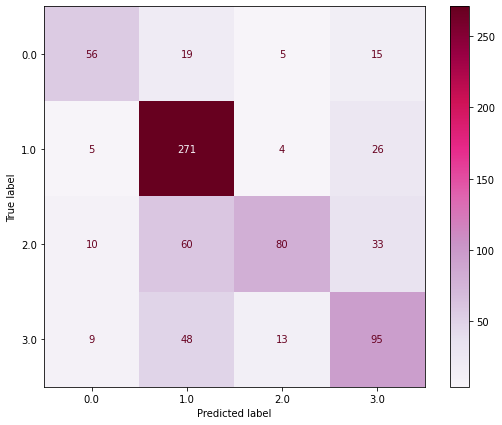

In [18]:
fig, ax = plt.subplots(figsize=(9,7))
cmd = ConfusionMatrixDisplay.from_predictions(y_true=y_test,y_pred=y_test_pred,
                                              ax=ax,cmap='PuRd')
plt.show()

A continuación se imprime un reporte de las metricas más relevantes de la clasificación, las cuales son:

- Precisión (precision): $\frac{tp}{tp + fp}$. La habilidad del clasificador para no etiquetar como positiva una muestra que es negativa.

- Exhaustividad (recall): $\frac{tp}{tp + fn}$. La habilidad del clasificador de encontrar todas las muestras positivas.

- Medida F ($F_\beta$ score): Media armónica de la precisión y exhaustividad, dónde el mejor valor es 1 y el peor 0.

[Más información](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_recall_fscore_support.html)

In [19]:
print(classification_report(y_true=y_test,y_pred=y_test_pred))

              precision    recall  f1-score   support

         0.0       0.70      0.59      0.64        95
         1.0       0.68      0.89      0.77       306
         2.0       0.78      0.44      0.56       183
         3.0       0.56      0.58      0.57       165

    accuracy                           0.67       749
   macro avg       0.68      0.62      0.64       749
weighted avg       0.68      0.67      0.66       749



Por último, el modelo es almacenado.

In [ ]:
model.save("BOF_nn_model.h5")